# 3D-Tracking-Beispiel

Mal ein neuer Versuch mit dem Tracking mit nächster Nachbarschaft.


In [436]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

import glob
from plotting_tools.colormaps import enhanced_colormap2
emap = enhanced_colormap2()

from plotting_tools.colormaps import radar_cmap as rc

from scipy import ndimage as ndi
from skimage import morphology

import haci as hci

import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking")
import object_tracking as ot
import tracking_common as tco

import networkx as nx

import operator

In [4]:
talos_home = "/vols/talos/home/stephan"
data_path = "{talos_home}/data".format(talos_home=talos_home)
track_data_path = "{dp}/radar_track/trackdata/hires/".format(dp=data_path)

Als erstes laden wir uns einen Beispielfall.

In [5]:
tracks = glob.glob("{}*.nc".format(track_data_path))

In [5]:
track_data = xr.open_dataset(tracks[0])

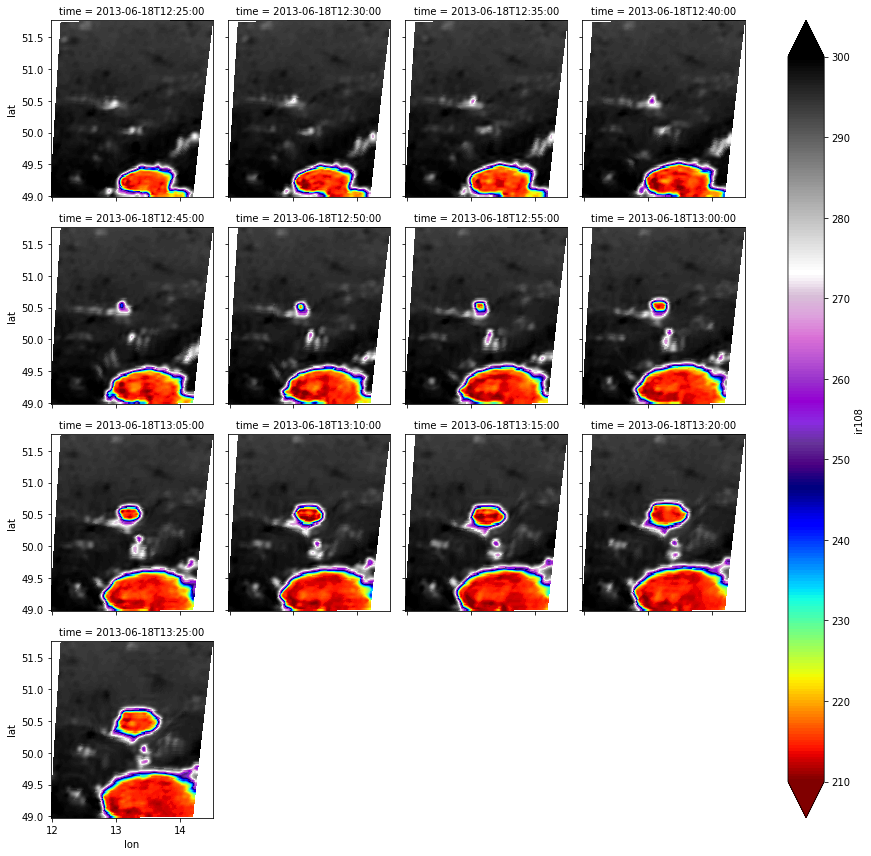

In [6]:
track_data.ir108.plot(x='lon',y='lat',col='time',col_wrap=4,vmin=210,vmax=300,cmap=emap)

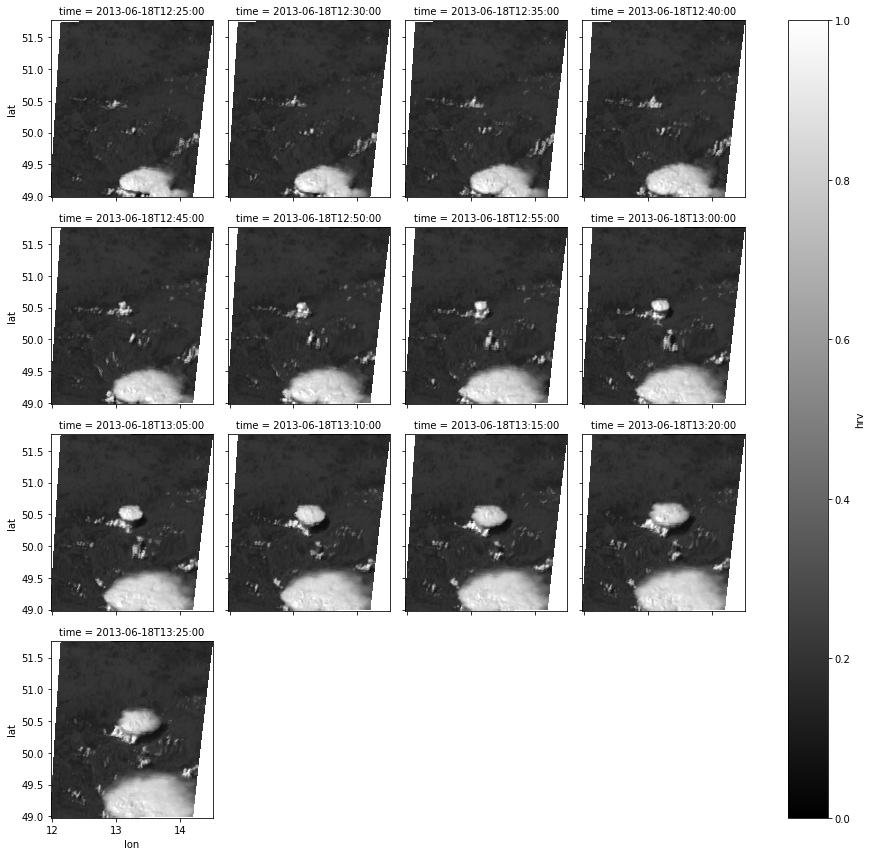

In [7]:
track_data.hrv.plot(x='lon',y='lat',col='time',col_wrap=4,vmin=0,vmax=1,cmap='gray')

Als nächstes benötigen wir eine passende Segmentierung.

In [8]:
hrv_segmented = np.ma.masked_less(track_data.hrv.data,0.3)

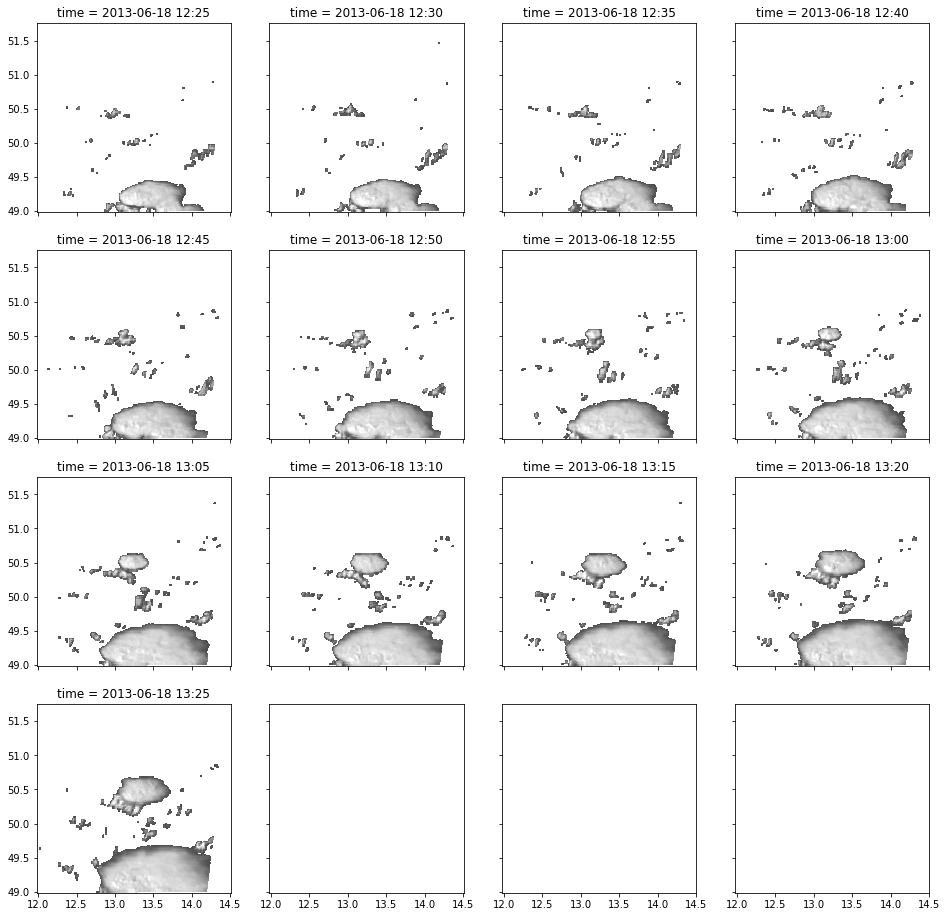

In [9]:
fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
axs=ax.ravel()
for i,h in enumerate(hrv_segmented):
    axs[i].pcolormesh(track_data.lon.data,
                     track_data.lat.data,
                     h, vmin=0, vmax=1, cmap='gray')
    axs[i].set_title("time = {}".format(pd.Timestamp(track_data.time.data[i]).strftime("%Y-%m-%d %H:%M")))

In [24]:
hrv_masks = np.array([~h.mask*1 for h in hrv_segmented])

In [157]:
hrv_labeled = []
hrv_dilated = []

for h in hrv_masks:
    l,nl = ndi.label(h,structure = np.ones((3,3)))
    
    l_dil = morphology.dilation(l,np.ones((3,3)))
    hrv_labeled.append(l)
    hrv_dilated.append(l_dil)

In [158]:
hrv_labeled = np.array(hrv_labeled)
hrv_dilated = np.array(hrv_dilated)

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


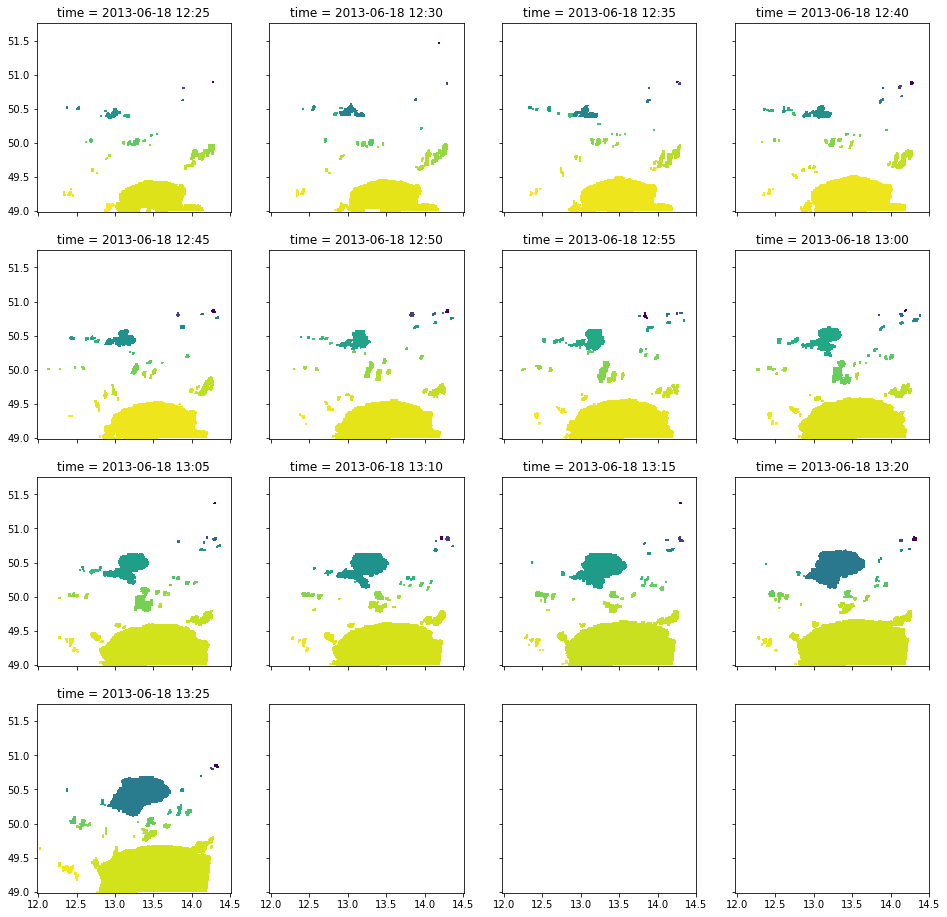

In [154]:
fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
axs=ax.ravel()
for i,l in enumerate(hrv_labeled):
    axs[i].pcolormesh(track_data.lon.data,
                     track_data.lat.data,
                     np.log(l))
    axs[i].set_title("time = {}".format(pd.Timestamp(track_data.time.data[i]).strftime("%Y-%m-%d %H:%M")))

In [155]:
def overlapping_objects(obj1,obj2):
    m = (obj1>0)&(obj2>0)
    id1 = obj1[m]
    id2 = obj2[m]
    idlink = np.stack((id1,id2),axis=-1)
    idlink = np.sort(np.unique(idlink,axis=0),axis=0)
    return (idlink[:,0],idlink[:,1])

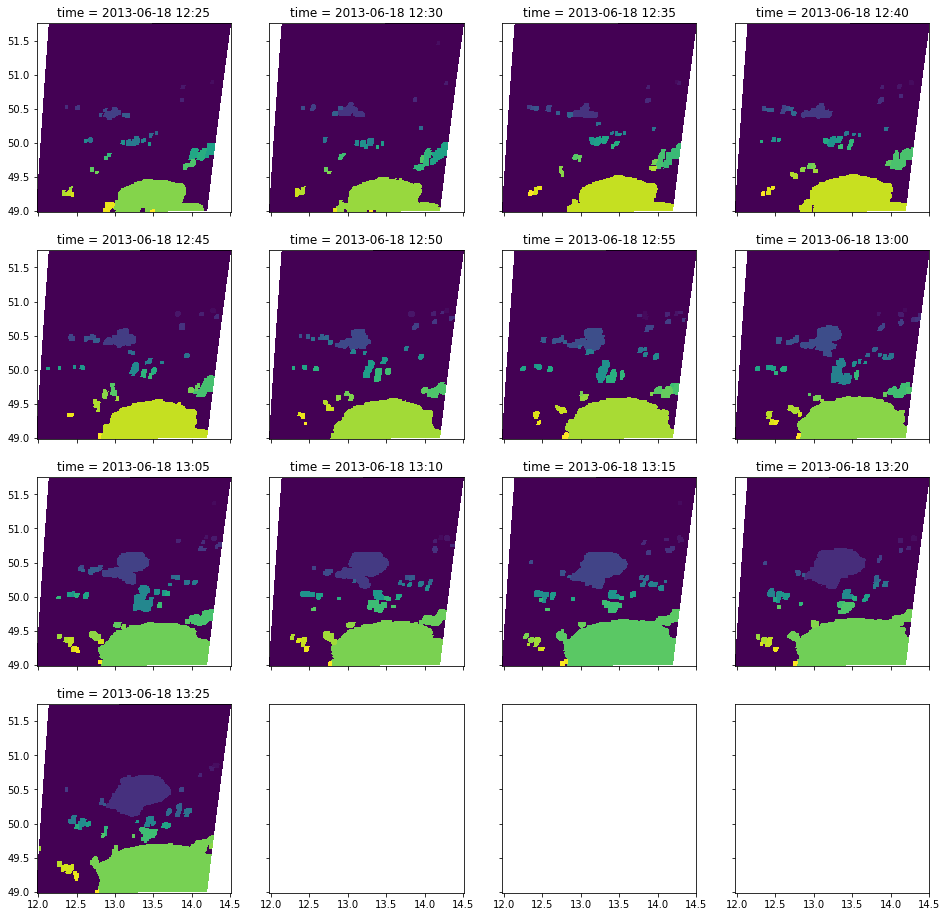

In [159]:
fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
axs=ax.ravel()
for i,o in enumerate(hrv_dilated):
    axs[i].pcolormesh(track_data.lon.data,
                     track_data.lat.data,
                     o)
    axs[i].set_title("time = {}".format(pd.Timestamp(track_data.time.data[i]).strftime("%Y-%m-%d %H:%M")))

In [160]:
label_t0,label_t1 = overlapping_objects(hrv_dilated[0],hrv_labeled[1])

In [161]:
label_t0,label_t1

(array([ 1,  3,  5,  6,  7,  8,  9, 12, 13, 13, 16, 17, 18, 19, 19, 20, 21,
        22, 23, 24, 25, 26, 26, 27, 28, 29, 31, 32], dtype=int32),
 array([ 2,  3,  4,  4,  4,  5,  8, 10, 11, 12, 13, 14, 15, 15, 17, 17, 18,
        18, 19, 20, 21, 22, 22, 22, 23, 23, 24, 26], dtype=int32))

In [148]:
connections = {t:{'t0':[],'t1':[]} for t in np.arange(0,hrv_labeled.shape[0])}

In [149]:
for i in xrange(hrv_labeled.shape[0]):
    if i < hrv_labeled.shape[0]-1:
        print i
        # grow by dilation
        omap = morphology.dilation(hrv_labeled[i],selem)
        # find overlapping objects for times t0 and t1
        label_t0,label_t1 = overlapping_objects(omap,hrv_labeled[i+1])
        
        connections[i]['t0'] = label_t0
        connections[i]['t1'] = label_t1        

0
1
2
3
4
5
6
7
8
9
10
11


In [162]:
overlap = ((hrv_dilated[0]>0) & (hrv_labeled[1]>0))

In [164]:
ids0 = hrv_dilated[0][overlap]
ids1 = hrv_labeled[1][overlap]

In [165]:
ids0,ids1 = overlapping_objects(hrv_dilated[0],hrv_labeled[1])

In [166]:
ids0,ids1

(array([ 1,  3,  5,  6,  7,  8,  9, 12, 13, 13, 16, 17, 18, 19, 19, 20, 21,
        22, 23, 24, 25, 26, 26, 27, 28, 29, 31, 32], dtype=int32),
 array([ 2,  3,  4,  4,  4,  5,  8, 10, 11, 12, 13, 14, 15, 15, 17, 17, 18,
        18, 19, 20, 21, 22, 22, 22, 23, 23, 24, 26], dtype=int32))

In [107]:
import fixed_colourbar as fc

Text(0.5,1,u'\xdcberlapp, t0 und t1')

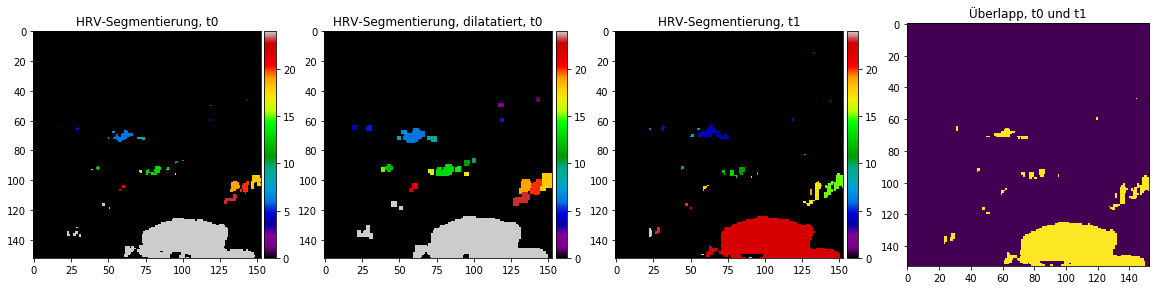

In [168]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
pl0 = ax[0].imshow(hrv_labeled[0],vmin=0,vmax=24,cmap='nipy_spectral')
ax[0].set_title("HRV-Segmentierung, t0")
fc.colourbar(pl0)
pl1 = ax[1].imshow(hrv_dilated[0],vmin=0,vmax=24,cmap='nipy_spectral')
ax[1].set_title("HRV-Segmentierung, dilatatiert, t0")
fc.colourbar(pl1)
pl2 = ax[2].imshow(hrv_labeled[1],vmin=0,vmax=24,cmap='nipy_spectral')
ax[2].set_title("HRV-Segmentierung, t1")
fc.colourbar(pl2)
ax[3].imshow(overlap)
ax[3].set_title(u"Überlapp, t0 und t1")

In [118]:
np.unique(hrv_labeled[1])

array([ 0,  1,  3,  5,  6,  9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23,
       24], dtype=int32)

In [18]:
hrv_dilated = ot.segmentation_dilation(track_data.hrv.data,0.3)
hrv_labeled = ot.segmentation_dilation(track_data.hrv.data,0.3,0,1)

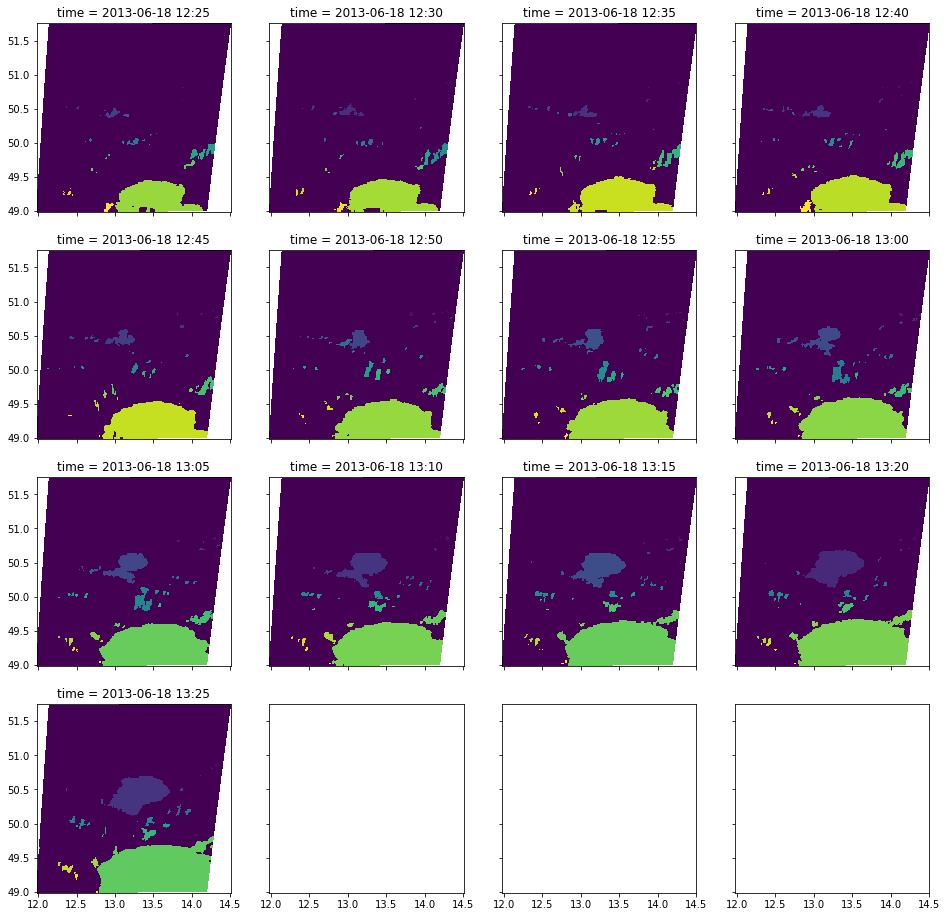

In [19]:
fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
axs=ax.ravel()
for i,o in enumerate(hrv_labeled):
    axs[i].pcolormesh(track_data.lon.data,
                     track_data.lat.data,
                     o)
    axs[i].set_title("time = {}".format(pd.Timestamp(track_data.time.data[i]).strftime("%Y-%m-%d %H:%M")))

In [22]:
tco.label_connections(hrv_dilated[0],hrv_labeled[1],'0','1')

{'0_0001': ['1_0002'],
 '0_0002': [],
 '0_0003': ['1_0003'],
 '0_0004': [],
 '0_0005': ['1_0005'],
 '0_0006': ['1_0004'],
 '0_0007': ['1_0004'],
 '0_0008': ['1_0008'],
 '0_0009': ['1_0004'],
 '0_0010': [],
 '0_0011': [],
 '0_0012': ['1_0010'],
 '0_0013': ['1_0016', '1_0011', '1_0013'],
 '0_0014': [],
 '0_0015': [],
 '0_0016': ['1_0012'],
 '0_0017': ['1_0014'],
 '0_0018': ['1_0015'],
 '0_0019': ['1_0018', '1_0021'],
 '0_0020': ['1_0015'],
 '0_0021': ['1_0019', '1_0020'],
 '0_0022': ['1_0020'],
 '0_0023': ['1_0015'],
 '0_0024': ['1_0018', '1_0022', '1_0023'],
 '0_0025': ['1_0024'],
 '0_0026': ['1_0025'],
 '0_0027': ['1_0026', '1_0031'],
 '0_0028': ['1_0027'],
 '0_0029': ['1_0028'],
 '0_0030': ['1_0027'],
 '0_0031': [],
 '0_0032': ['1_0029'],
 '0_0033': ['1_0026']}

In [33]:
objects = generate_graph_from_components(hrv_labeled,hrv_dilated,np.arange(0,13,1))

In [ ]:
ot

In [40]:
tgraph = ot.sort_graph_by_timesteps(objects[1][0])
print(tgraph)

{0: ['0_0013'], 1: ['1_0011', '1_0013', '1_0016'], 2: ['2_0019', '2_0020'], 3: ['3_0025', '3_0020', '3_0019'], 4: ['4_0016', '4_0022'], 5: ['5_0021', '5_0025'], 6: ['6_0020', '6_0025'], 7: ['7_0017'], 8: ['8_0020'], 9: ['9_0024', '9_0026', '9_0027', '9_0025', '9_0019'], 10: ['10_0030', '10_0031', '10_0022', '10_0028'], 11: ['11_0025', '11_0021', '11_0024', '11_0027', '11_0016'], 12: ['12_0022', '12_0015']}


In [43]:
for node in objects[1][0].nodes():
    print objects[1][0][node]

{'10_0031': {}, '12_0022': {}}
{'5_0021': {}, '3_0020': {}, '3_0019': {}}
{'11_0024': {}, '9_0026': {}}
{'11_0025': {}, '9_0026': {}, '11_0027': {}}
{'10_0028': {}}
{'4_0022': {}}
{'4_0016': {}, '2_0020': {}}
{'11_0024': {}, '11_0025': {}, '11_0027': {}}
{'6_0020': {}, '8_0020': {}, '6_0025': {}}
{'9_0024': {}, '9_0019': {}, '9_0026': {}, '9_0027': {}, '7_0017': {}}
{'8_0020': {}, '10_0022': {}, '10_0028': {}}
{'1_0011': {}, '1_0013': {}, '1_0016': {}}
{'8_0020': {}, '10_0030': {}, '10_0031': {}}
{'8_0020': {}}
{'10_0030': {}, '12_0022': {}}
{'4_0016': {}, '6_0020': {}}
{'10_0031': {}, '12_0022': {}}
{'6_0025': {}, '4_0022': {}}
{'0_0013': {}, '2_0020': {}}
{'0_0013': {}, '2_0019': {}}
{'0_0013': {}, '2_0019': {}}
{'9_0024': {}, '9_0019': {}, '11_0016': {}}
{'10_0028': {}}
{'1_0013': {}, '3_0019': {}, '1_0016': {}}
{'10_0022': {}, '12_0015': {}}
{'3_0025': {}, '5_0025': {}}
{'9_0024': {}, '9_0025': {}, '11_0021': {}}
{'5_0021': {}, '7_0017': {}}
{'7_0017': {}, '5_0025': {}}
{'4_0016': 

In [46]:
object_id = ot.get_wanted_object_id(hrv_labeled)
print("gesuchtes Objekt: {}".format(object_id))

gesuchtes Objekt: 17


In [49]:
object_graph = ot.get_wanted_graph(objects[1],"{:d}_{:04d}".format(13//2,object_id))

In [77]:
# sort graph nodes by time    
wanted_graph = ot.sort_graph_by_timesteps(object_graph)

# find main track of the object
main_track = ot.get_main_track(hrv_labeled,wanted_graph,"{:d}_{:04d}".format(13//2,object_id))

In [78]:
main_track_data = []

for tp in main_track:
    tidx = int(tp.split("_")[0])
    obj_id = int(tp.split("_")[1])
    
    obj_mask = ~np.ma.masked_not_equal(hrv_labeled[tidx],obj_id).mask*1
    
    data = track_data.hrv.data[tidx].copy()
    data[np.where(obj_mask!=1)] = 0
    
    main_track_data.append(data)

In [79]:
main_track = np.array(main_track_data)

In [80]:
plt.imshow(~obj_mask.mask*1)

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

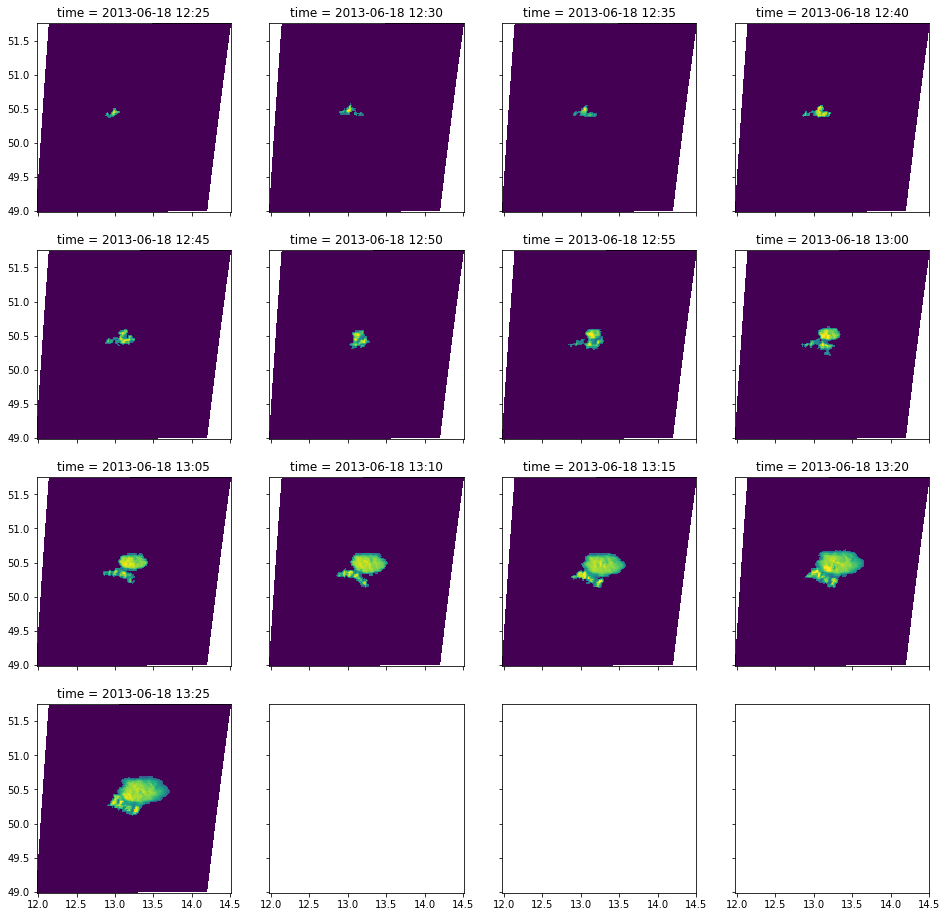

In [81]:
fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
axs=ax.ravel()
for i,o in enumerate(main_track):
    axs[i].pcolormesh(track_data.lon.data,
                     track_data.lat.data,
                     o)
    axs[i].set_title("time = {}".format(pd.Timestamp(track_data.time.data[i]).strftime("%Y-%m-%d %H:%M")))

In [272]:
reload(ot)

<module 'object_tracking' from '/vols/talos/home/stephan/utils/tracking/object_tracking.py'>

In [273]:
main_track = ot.get_track_from_labeled_field(hrv_labeled)

In [274]:
main_track

['0_0002',
 '1_0048',
 '2_0001',
 '3_0001',
 '4_0061',
 '5_0057',
 '6_0060',
 '7_0049',
 '8_0039',
 '9_0041',
 '10_0036',
 '11_0023',
 '12_0022']

In [275]:
main_track_data = []

for tp in main_track:
    tidx = int(tp.split("_")[0])
    obj_id = int(tp.split("_")[1])
    
    obj_mask = ~np.ma.masked_not_equal(hrv_labeled[tidx],obj_id).mask*1
    
    data = track_data.hrv.data[tidx].copy()
    data[np.where(obj_mask!=1)] = 0
    
    main_track_data.append(data)

In [276]:
oid= "{}_{}".format(tracks[0].split("/")[-1].split(".")[0].split("_")[-2],
                    tracks[0].split("/")[-1].split(".")[0].split("_")[-1])

In [277]:
for tr in tracks:
    track_data = xr.open_dataset(tr)
    
    hrv_labeled = ot.segmentation_dilation(track_data.hrv.data,0.4,0,1)
    
    main_track = ot.get_track_from_labeled_field(hrv_labeled)
    
    main_track_data = []

    for tp in main_track:
        tidx = int(tp.split("_")[0])
        obj_id = int(tp.split("_")[1])

        obj_mask = ~np.ma.masked_not_equal(hrv_labeled[tidx],obj_id).mask*1

        data = track_data.hrv.data[tidx].copy()
        data[np.where(obj_mask!=1)] = 0

        main_track_data.append(data)
        
    fig,ax = plt.subplots(4,4,figsize=(16,16),sharex=True,sharey=True)
    axs=ax.ravel()
    for i,o in enumerate(np.array(main_track_data)):
        axs[i].pcolormesh(track_data.lon.data,
                          track_data.lat.data,
                          o,vmin=0,vmax=1,cmap='gray')
        axs[i].set_title("time = {}".format(pd.Timestamp(track_data.time.data[i]).strftime("%Y-%m-%d %H:%M")))
    
    oid= "{}_{}".format(tr.split("/")[-1].split(".")[0].split("_")[-2],
                        tr.split("/")[-1].split(".")[0].split("_")[-1])    
    plt.savefig("/vols/talos/home/stephan/proj/2019-01_trackingstudie/pics/dilation_segmentation/{}.png".format(oid))
    
    plt.close("all")

KeyboardInterrupt: 

In [278]:
tr = tracks[6]
print(tr)

/vols/talos/home/stephan/data/radar_track/trackdata/hires/haci_trackdata_20130804_133.nc


In [279]:
track_data = xr.open_dataset(tr)

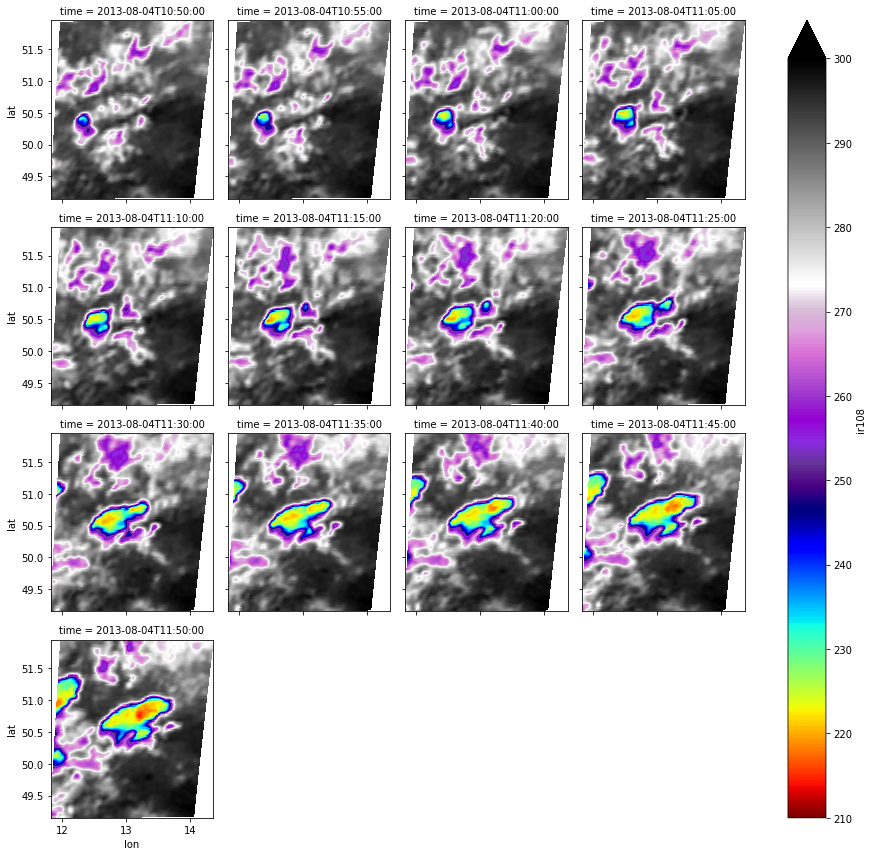

In [280]:
track_data.ir108.plot(x='lon',y='lat',col='time',col_wrap=4,vmin=210,vmax=300,cmap=emap)

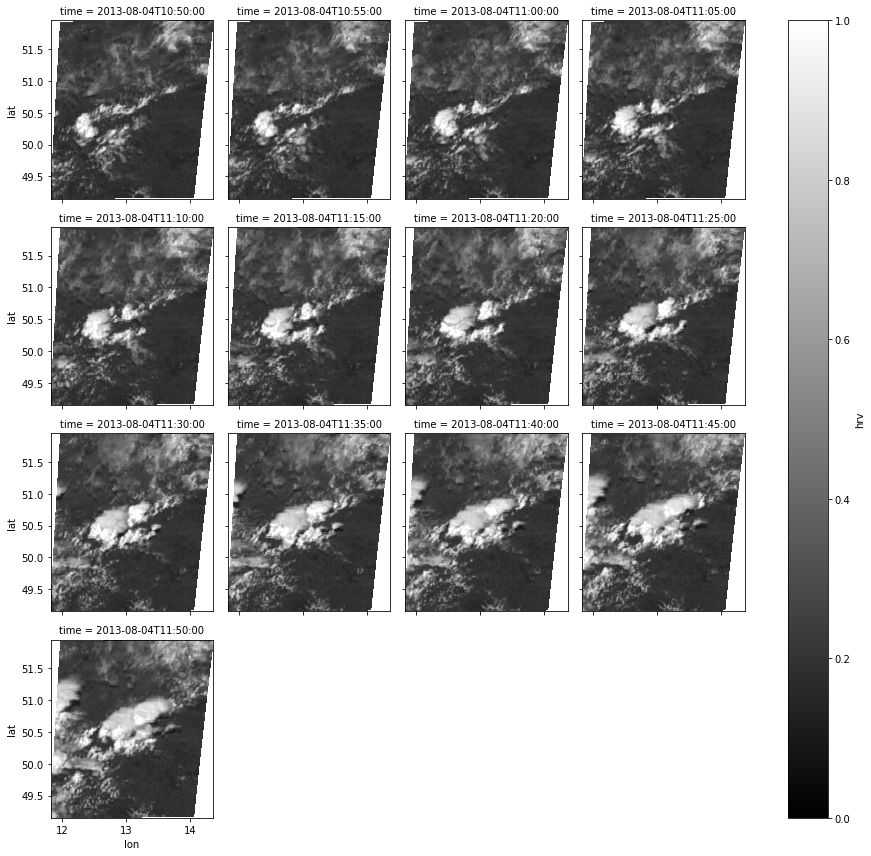

In [281]:
track_data.hrv.plot(x='lon',y='lat',col='time',col_wrap=4,vmin=0,vmax=1,cmap='gray')

In [282]:
hrv_segm = np.ma.masked_less(track_data.hrv.data,0.4)

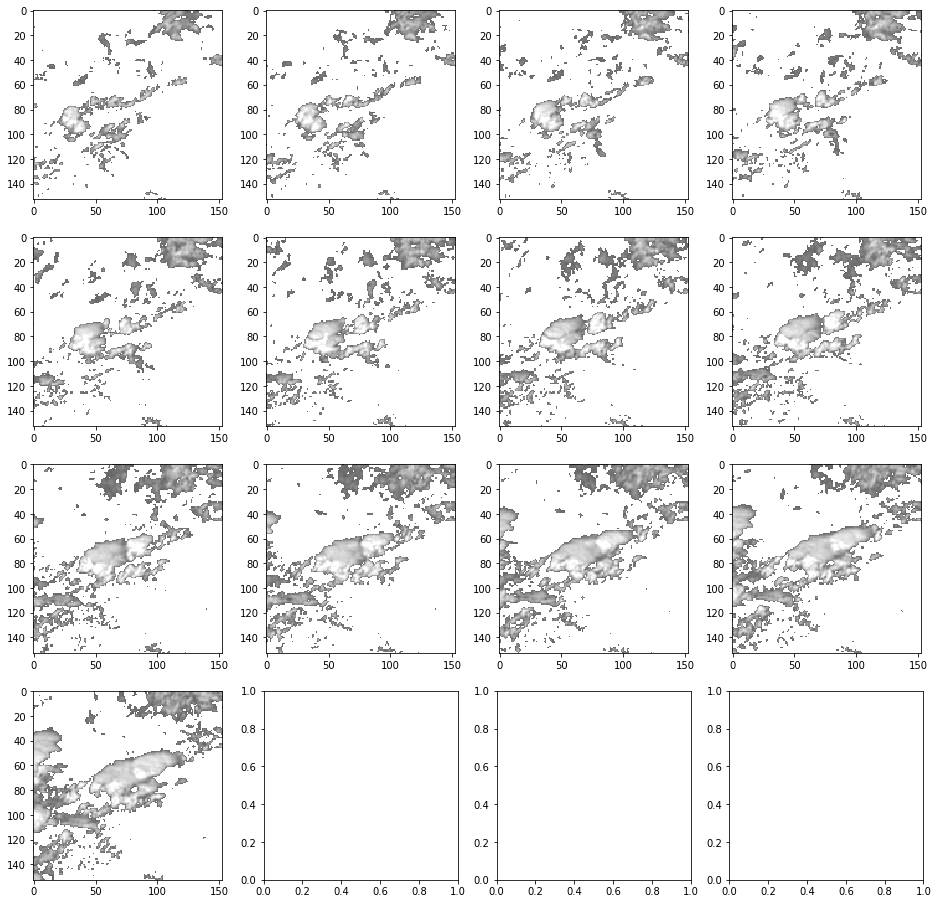

In [283]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs=ax.ravel()

for i,h in enumerate(hrv_segm):
    axs[i].imshow(h,vmin=0,vmax=1,cmap='gray')

In [427]:
hrv_labeled = ot.segmentation_dilation(track_data.hrv.data,0.5,0,1)

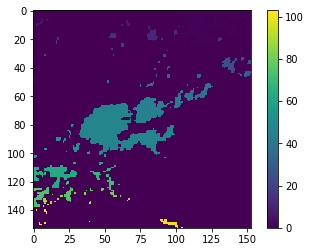

In [428]:
plt.imshow(hrv_labeled[6])
plt.colorbar()

In [429]:
connections = ot.generate_graph_from_components(hrv_labeled,
                                                np.arange(0,13,1),0,'centroid',3)

In [430]:
object_id = ot.get_wanted_object_id(hrv_labeled)
print(object_id)

45


In [431]:
object_graph = ot.get_wanted_graph(connections[1],"{:d}_{:04d}".format(len(track_data.hrv.data)//2,object_id))

In [432]:
wanted_graph = ot.sort_graph_by_timesteps(object_graph)

In [433]:
main_track = ot.get_main_track(hrv_labeled,
                               wanted_graph,
                               "{:d}_{:04d}".format(len(track_data.hrv.data)//2,object_id),
                               'o')

In [434]:
main_track_data = []

for tp in main_track:
    tidx = int(tp.split("_")[0])
    obj_id = int(tp.split("_")[1])
    
    obj_mask = ~np.ma.masked_not_equal(hrv_labeled[tidx],obj_id).mask*1
    
    data = track_data.hrv.data[tidx].copy()
    data[np.where(obj_mask!=1)] = 0
    
    main_track_data.append(data)

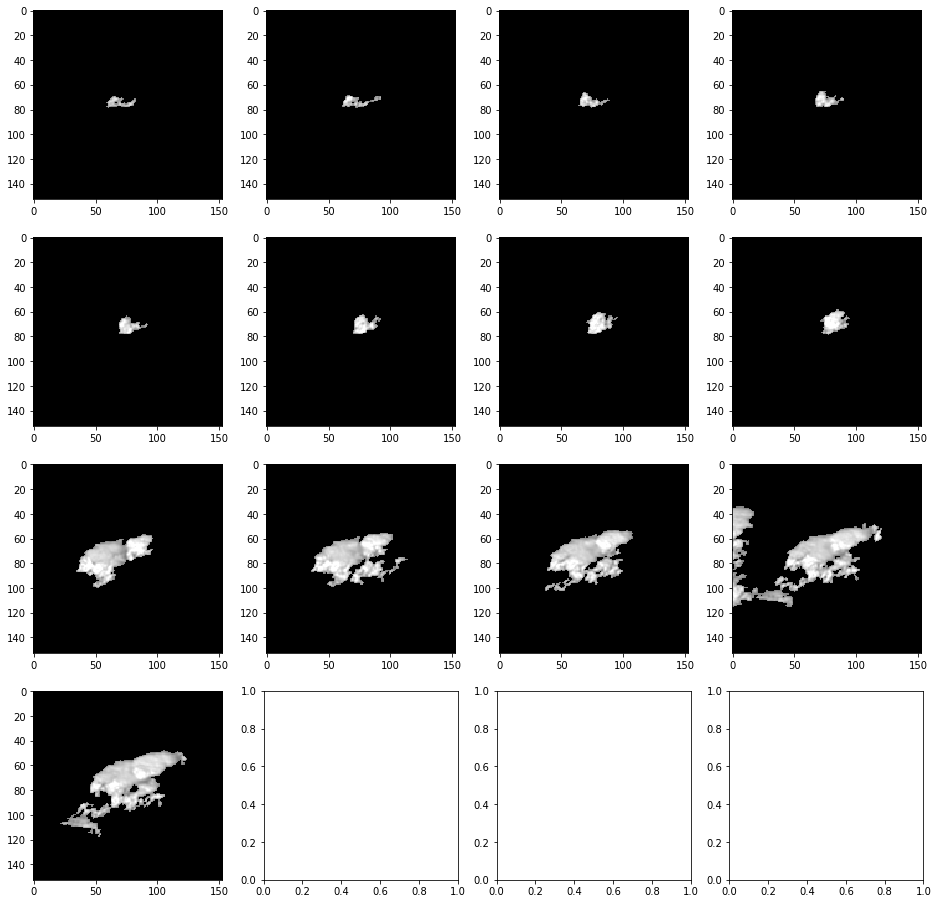

In [435]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs=ax.ravel()

for i,h in enumerate(main_track_data):
    #axs[i].imshow(track_data.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    axs[i].imshow(h,vmin=0,vmax=1,cmap='gray')

In [501]:
ir_labeled = ot.segmentation_dilation(track_data.ir108.data,265,0,1,op=operator.lt)

In [502]:
connections = ot.generate_graph_from_components(ir_labeled,
                                                np.arange(0,13,1),0,'centroid',3)

In [503]:
object_id = ot.get_wanted_object_id(ir_labeled)

In [504]:
print(object_id)

11


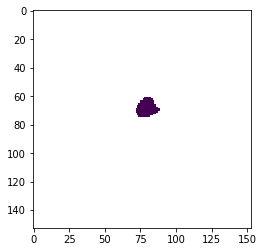

In [505]:
plt.imshow(np.ma.masked_not_equal(ir_labeled[6], object_id))

In [506]:
object_graph = ot.get_wanted_graph(connections[1],"{:d}_{:04d}".format(len(track_data.ir108.data)//2,object_id))

In [507]:
wanted_graph = ot.sort_graph_by_timesteps(object_graph)

In [508]:
main_track = ot.get_main_track(ir_labeled,
                               wanted_graph,
                               "{:d}_{:04d}".format(len(track_data.ir108.data)//2,object_id),
                               'o')

AttributeError: 'NoneType' object has no attribute 'split'

In [497]:
main_track

['0_0001',
 '1_0001',
 '2_0001',
 '3_0001',
 '4_0001',
 '5_0001',
 '6_0001',
 '7_0002',
 '8_0002',
 '9_0002',
 '10_0002',
 '11_0002',
 '12_0002']

In [498]:
main_track_data = []

for tp in main_track:
    tidx = int(tp.split("_")[0])
    obj_id = int(tp.split("_")[1])
    
    obj_mask = ~np.ma.masked_not_equal(ir_labeled[tidx],obj_id).mask*1
    
    data = track_data.ir108.data[tidx].copy()
    data[np.where(obj_mask!=1)] = 0
    
    main_track_data.append(data)

In [499]:
reload(ot)

<module 'object_tracking' from '/vols/talos/home/stephan/utils/tracking/object_tracking.pyc'>

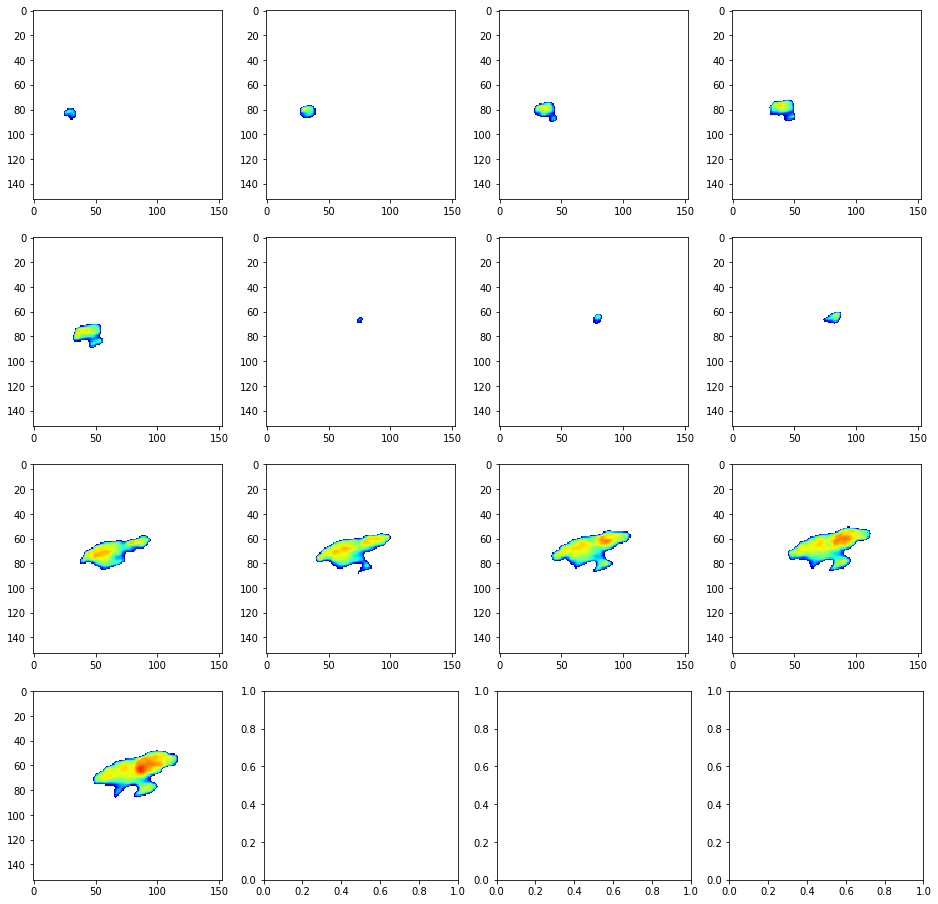

In [500]:
fig,ax = plt.subplots(4,4,figsize=(16,16))
axs=ax.ravel()

for i,h in enumerate(main_track_data):
    #axs[i].imshow(track_data.hrv.data[i],vmin=0,vmax=1,cmap='gray')
    axs[i].imshow(np.ma.masked_less(h,210),vmin=210,vmax=300,cmap=emap)